In [ ]:
import random
import json
from collections import defaultdict
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from gnm import MemoryLLMChatWrapper, build_model
import torch.nn.functional as F
from instructions import get_learning_instruction
from config_memoryllm_train import MemoryllmTrainConfig, DistributedCfg, DataCfg, SamplingCfg, ModelCfg, LoopCtrlCfg, LoggingCfg
import matplotlib.pyplot as plt

# Dataset creation

In [ ]:
# # Construct Dataset
# '''
#     dataset = [
#     {
#         "target_fact": "...",
#         "learning_instruction": "...",
#         "examples": [
#             {
#               "document": "...",
#               "distractor_fact": {}
#             },
#             {"document": "...",
#              "distractor_fact": {},
#             ...
#         ],
#     }
#     ]
# '''

# with open("../data/counterfact_with_categories/test.json","r") as f:
#     test_facts = json.load(f)

# # subcategories =["continents","science_academia_law_medicine_related_occupation","northern_central_european_languages","religion"]
# subcategories_to_target =[ "us_cities_or_states",
#                           "non_us_cities_or_states",
#                           "major_western_european_languages",
#                           "eastern_european_mediterranean_languages",
#                           "tech_industrial_or_gaming_company",
#                           "music_or_art_related_occupation",
#                           ]
# subcategories_for_distractor =["country",
#                                "asian_middle_eastern_languages_and_pacific",
#                                "car_company",
#                                "politics_entertainment_religion_related_occupation",
#                                "sports_related_occupation",
#                                "TV_entertainment_or_news_organization",
#                                ]

# # subcategories_to_target =[ "religion"
# #                           ]
# # subcategories_for_distractor =["continents",
# #                                "science_academia_law_medicine_related_occupation",
# #                                "northern_central_european_languages"
# #                                ]

# facts_in_subcategories = []
# facts_not_in_subcategories = []
# for fact in test_facts:
#     if fact['subcategory'] in subcategories_to_target:
#         facts_in_subcategories.append(fact)
#     elif fact['subcategory'] in subcategories_for_distractor:
#         facts_not_in_subcategories.append(fact)



# dataset = []
# for i in range(0,20):
#     target_fact = random.choice(facts_in_subcategories)
#     target_fact_text = target_fact['paraphrase_prompts'][0] + " " + target_fact['requested_rewrite']['target_new']['str']
#     target_to_learn = target_fact['subcategory']

#     distractor_facts = random.sample(facts_not_in_subcategories,60)

#     examples = []
#     # for distractor_fact in distractor_facts:
#     # do a stride where we pull 6 distractor facts at a time to make 10 examples
#     for j in range(0,10):
#         distractor_facts_temp = distractor_facts[j*6:(j+1)*6]
#         facts_to_add_texts = [target_fact_text]
#         for distractor_fact in distractor_facts_temp:
#             # distractor_fact = random.choice(distractor_facts_temp)
#             distractor_fact_text = distractor_fact['paraphrase_prompts'][0] + " " + distractor_fact['requested_rewrite']['target_new']['str']
#             # facts_to_add_texts = [target_fact_text, distractor_fact_text]
#             facts_to_add_texts.append(distractor_fact_text)
#         random.shuffle(facts_to_add_texts)
#         document = f"Here is a document of new facts: \n"
#         for text in facts_to_add_texts:
#             document += f"*{text}\n"
#         examples.append({'document':document,
#                         'distractor_fact':distractor_fact})
        
#     dataset.append({
#         "target_fact": target_fact,
#         "learning_instruction": get_learning_instruction(target_to_learn, random_sampling=False),
#         "examples": examples
#     })

# with open("../data/write_invariance_dataset_test_2.json","w") as f:
#     json.dump(dataset,f,indent=4)

# Model loading and dataset loading

In [ ]:
# # Load models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cfg = MemoryllmTrainConfig(
#         run_name       = "run",
#         seed           = 42,
#         distributed    = DistributedCfg(cuda_visible_devices="0", nproc_per_node=4, master_port=29512),
#         data           = DataCfg(),
#         sampling       = SamplingCfg(),
#         opt            = None,
#         model          = ModelCfg(model='memoryllm_chat'),
#         loop           = LoopCtrlCfg(),
#         log            = LoggingCfg(),
#     )


# print("Loading gnm model...")
# gnm_model_wrapper = build_model(cfg)
# print("Loading state dict of model...")
# gnm_state_dict = torch.load("../shared_models/mixed_documents/memoryllm/exp3_memoryllm_model.pth", map_location='cpu')
# gnm_model_wrapper.load_state_dict(gnm_state_dict)

# print("Loading ablation model...")
# ablation_model_wrapper = build_model(cfg)
# print("Loading state dict of model...")
# ablation_state_dict = torch.load("../shared_models/mixed_documents/memoryllm_memory_ablation/exp3_memoryllm_ablation_model.pth", map_location='cpu')
# ablation_model_wrapper.load_state_dict(ablation_state_dict)
# print("Finished loading model...")


# gnm_model_wrapper.eval()
# gnm_model_wrapper.to(device)

# ablation_model_wrapper.eval()
# ablation_model_wrapper.to(device)

In [64]:
# load dataset
print("Loading dataset...")
with open("../data/write_invariance_dataset_final.json","r") as f:
    dataset = json.load(f)
print("Finished loading dataset...")

Loading dataset...
Finished loading dataset...


In [39]:
@torch.no_grad()
def get_candidate_write(wrapper: MemoryLLMChatWrapper,
                        learning_instruction: str,
                        document: str):
    """
    Returns candidate memory write without committing it.
    Output shape: [L, num_tokens, d]
    """
    wrapper.reset_memory()
    wrapper.model.eval()

    memory_context = (
        f"<|learning_instruction_start|>{learning_instruction}<|learning_instruction_end|>"
        f"<|document_start|>{document}<|document_end|>"
    )

    ctx_ids = wrapper.tokenizer(
        memory_context,
        return_tensors="pt",
        add_special_tokens=False
    ).input_ids.to(wrapper.model.device)

    # IMPORTANT: update_memory=False, output_delta_memory=True
    delta = wrapper.model.inject_memory(
        ctx_ids,
        update_memory=False
    )

    # delta is [1, L, num_tokens, d]
    # return delta[0].detach().cpu()  # -> [L, 256, d]
    return delta[0].detach()  # stay on GPU


def collect_candidate_writes(wrapper, set_of_10_docs, limit_docs: int = None, identical_doc_test: bool = False):
    """
    Returns tensor of shape:
      [N, L, 256, d]
    """
    writes = []
    learning_instruction = set_of_10_docs["learning_instruction"]
    

    # if limit_docs is not None:
    #     docs = set_of_20_docs["documents"][:limit_docs]
    # else:
    examples = set_of_10_docs["examples"]
        
    for example in examples:
        doc = example["document"]
        w = get_candidate_write(
            wrapper,
            learning_instruction=learning_instruction,
            document=doc
        )
        writes.append(w)

    return torch.stack(writes, dim=0)

import torch.nn.functional as F

def layerwise_flat_cosine(writes: torch.Tensor):
    """
    writes: [N, L, 256, d]

    Returns:
      sims: [L, N, N] cosine similarity matrices
    """
    N, L, T, D = writes.shape
    x = writes.reshape(N, L, T * D)   # [N, L, 256*d]
    x = F.normalize(x, dim=-1)

    sims = torch.einsum("nld,mld->lnm", x, x)
    return sims

def summarize_similarities(sims: torch.Tensor):
    """
    sims: [L, N, N]
    """
    L, N, _ = sims.shape
    mask = ~torch.eye(N, dtype=torch.bool)

    off_diag = sims[:, mask]                 # [L, N*(N-1)]
    mean_per_layer = off_diag.mean(dim=1)    # [L]
    mean_overall = off_diag.mean()           

    return mean_per_layer, mean_overall


# Analysis 1: Cosine Similarity

In [40]:

## GNM
gnm_mean_overall_list = []
gnm_mean_per_layer_list = []

for i, set_of_10_docs in enumerate(dataset): # limit to 2 for testing
    print(f"Processing new set of examples... ({i+1}/{len(dataset)})")
    writes = collect_candidate_writes(gnm_model_wrapper, set_of_10_docs) # writes.shape == [N, L, 256, d]
    sims = layerwise_flat_cosine(writes)
    mean_per_layer, mean_overall = summarize_similarities(sims)
    gnm_mean_overall_list.append(mean_overall.item())
    gnm_mean_per_layer_list.append(mean_per_layer.detach().cpu().float().numpy())

# Finally, average across all target facts
print(f"Averaging across all examples...")
gnm_mean_overall_final = np.mean(gnm_mean_overall_list)
gnm_mean_per_layer_final = np.mean(np.stack(gnm_mean_per_layer_list, axis=0), axis=0)  # [L]
print("Final GNM Mean Overall Cosine Similarity:", gnm_mean_overall_final)
print("Final GNM Mean Per Layer Cosine Similarity:", gnm_mean_per_layer_final)


## ABLATION

ablation_mean_overall_list = []
ablation_mean_per_layer_list = []

for i, set_of_10_docs in enumerate(dataset): # limit to 2 for testing
    print(f"Processing new set of examples... ({i+1}/{len(dataset)})")
    writes = collect_candidate_writes(ablation_model_wrapper, set_of_10_docs) # writes.shape == [N, L, 256, d]
    sims = layerwise_flat_cosine(writes)
    mean_per_layer, mean_overall = summarize_similarities(sims)
    ablation_mean_overall_list.append(mean_overall.item())
    ablation_mean_per_layer_list.append(mean_per_layer.detach().cpu().float().numpy())

# Finally, average across all target facts
print(f"Averaging across all examples...")
ablation_mean_overall_final = np.mean(ablation_mean_overall_list)
ablation_mean_per_layer_final = np.mean(np.stack(ablation_mean_per_layer_list, axis=0), axis=0)  # [L]
print("Final ablation Mean Overall Cosine Similarity:", ablation_mean_overall_final)
print("Final ablationMean Per Layer Cosine Similarity:", ablation_mean_per_layer_final)


Processing new set of examples... (1/20)
Processing new set of examples... (2/20)
Processing new set of examples... (3/20)
Processing new set of examples... (4/20)
Processing new set of examples... (5/20)
Processing new set of examples... (6/20)
Processing new set of examples... (7/20)
Processing new set of examples... (8/20)
Processing new set of examples... (9/20)
Processing new set of examples... (10/20)
Processing new set of examples... (11/20)
Processing new set of examples... (12/20)
Processing new set of examples... (13/20)
Processing new set of examples... (14/20)
Processing new set of examples... (15/20)
Processing new set of examples... (16/20)
Processing new set of examples... (17/20)
Processing new set of examples... (18/20)
Processing new set of examples... (19/20)
Processing new set of examples... (20/20)
Averaging across all examples...
Final GNM Mean Overall Cosine Similarity: 0.42109375
Final GNM Mean Per Layer Cosine Similarity: [0.16723633 0.26313478 0.33271486 0.400

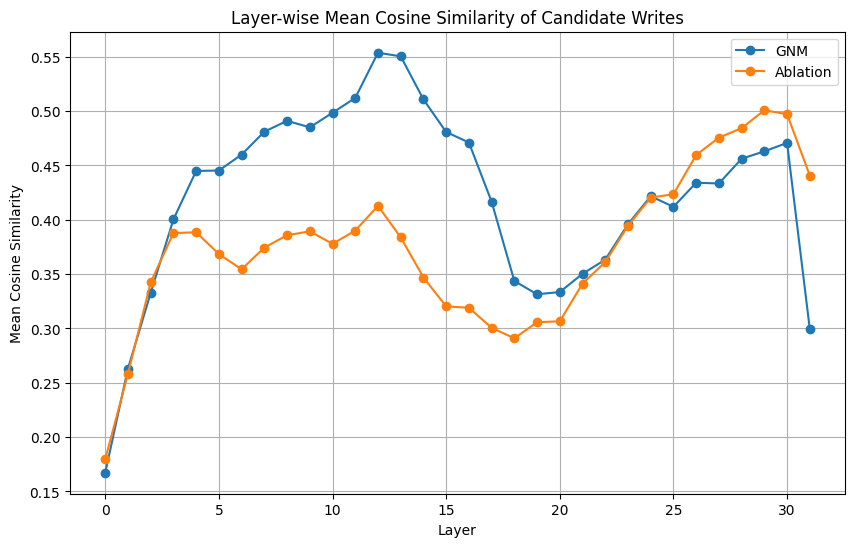

In [41]:
save_path = "../saved_evals/analysis/cosine_similarity_results.json"
with open(save_path,"w") as f:
    json.dump({
        "GNM":{
            "mean_overall_cosine_similarity": gnm_mean_overall_final,
            "mean_per_layer_cosine_similarity": gnm_mean_per_layer_final.tolist()
        },
        "ablation":{
            "mean_overall_cosine_similarity": ablation_mean_overall_final,
            "mean_per_layer_cosine_similarity": ablation_mean_per_layer_final.tolist()
        }
    },f,indent=4)


# print a chart of the mean_per_layer_cosine_similarity here
plt.figure(figsize=(10,6))
plt.plot(gnm_mean_per_layer_final, label="GNM", marker='o')
plt.plot(ablation_mean_per_layer_final, label="Ablation", marker='o')
plt.xlabel("Layer")
plt.ylabel("Mean Cosine Similarity")
plt.title("Layer-wise Mean Cosine Similarity of Candidate Writes")
plt.legend()
plt.grid()
plt.savefig("../saved_evals/analysis/write_invariance_layerwise_cosine_similarity_multidocs.png")
plt.show()

# analysis 2 - compressibility

In [42]:

def analyze_update_subspaces(gnm_wrapper, ablation_wrapper, set_of_10_docs, limit_docs=10, n_components=10):
    """
    Use SVD to identify the principal directions of memory updates.
    Compare the subspaces used by GNM vs ablation.
    """
    learning_instruction = set_of_10_docs["learning_instruction"]
    examples = set_of_10_docs["examples"]
    
    results_per_layer = []
    
    # Collect all updates
    gnm_updates = []
    abl_updates = []
    
    for example in examples:
        gnm_updates.append(get_candidate_write(gnm_wrapper, learning_instruction, example["document"]))
        abl_updates.append(get_candidate_write(ablation_wrapper, learning_instruction, example["document"]))
    
    gnm_updates = torch.stack(gnm_updates, dim=0).float()  # [N, L, 256, d] - convert to float32
    abl_updates = torch.stack(abl_updates, dim=0).float()  # convert to float32
    
    L = gnm_updates.shape[1]
    
    for l in range(L):
        gnm_layer = gnm_updates[:, l, :, :].reshape(-1, gnm_updates.shape[3])  # [N*256, d]
        abl_layer = abl_updates[:, l, :, :].reshape(-1, abl_updates.shape[3])
        
        # SVD to get principal components
        U_gnm, S_gnm, _ = torch.svd(gnm_layer)
        U_abl, S_abl, _ = torch.svd(abl_layer)
        
        # Compare top-k principal directions
        top_gnm = U_gnm[:, :n_components]  # [N*256, k]
        top_abl = U_abl[:, :n_components]
        
        # Subspace similarity (via Grassmannian distance approximation)
        subspace_overlap = torch.mm(top_gnm.t(), top_abl)  # [k, k]
        singular_vals = torch.svd(subspace_overlap)[1]  # singular values
        
        # Principal angle between subspaces
        principal_angles = torch.acos(torch.clamp(singular_vals, -1, 1))
        
        results_per_layer.append({
            'layer': l,
            'gnm_variance_explained': (S_gnm[:n_components]**2).sum().item() / (S_gnm**2).sum().item(),
            'abl_variance_explained': (S_abl[:n_components]**2).sum().item() / (S_abl**2).sum().item(),
            'principal_angles': principal_angles.cpu().numpy().tolist(),
            'mean_principal_angle': principal_angles.mean().item(),
        })
    
    return results_per_layer

# Analyze all layers
subspace_all = analyze_update_subspaces(
    gnm_model_wrapper, 
    ablation_model_wrapper, 
    dataset[0],
    limit_docs=10
)

# Extract metrics per layer
layers = []
gnm_var_exp = []
abl_var_exp = []

for l, result in enumerate(subspace_all):
    layers.append(l)
    gnm_var_exp.append(result['gnm_variance_explained'])
    abl_var_exp.append(result['abl_variance_explained'])



In [44]:
# save the data
save_path = "../saved_evals/analysis/subspace_analysis_results.json"
with open(save_path,"w") as f:
    json.dump({
        "per_layer_results": subspace_all
    },f,indent=4)

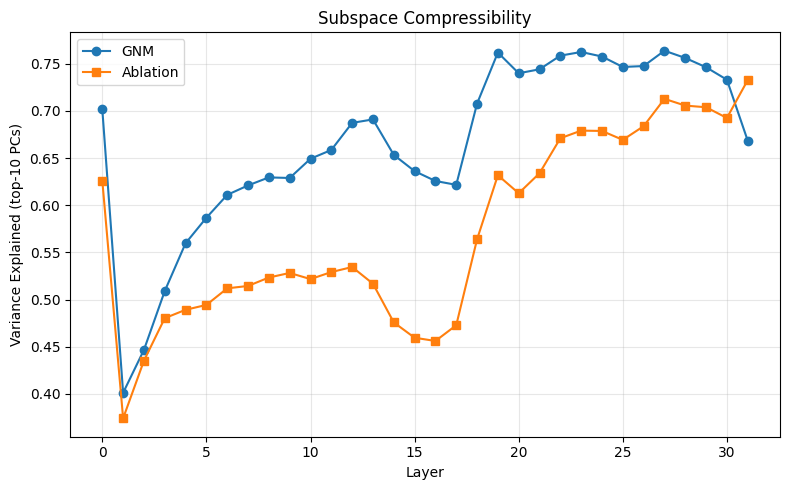

In [62]:
# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

# Variance explained
ax1.plot(layers, gnm_var_exp, label='GNM', marker='o')
ax1.plot(layers, abl_var_exp, label='Ablation', marker='s')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Variance Explained (top-10 PCs)')
ax1.set_title('Subspace Compressibility')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../saved_evals/analysis/subspace_compressibility_2.png', dpi=150, bbox_inches='tight')
plt.show()

# Analysis 3 - causal flip

In [ ]:
# ## LAYER IMPORTANCE VIA SWAPPING ANALYSIS (ACCURACY + SELECTIVITY)



# def evaluate_model_on_dataset(wrapper, dataset_sample, limit_docs=10):
#     """
#     Measures both accuracy and selectivity.
    
#     Returns:
#       accuracy: float (mean accuracy on target facts)
#       selectivity: float (mean accuracy on non-target facts)
#     """
#     from instructions import update_format
#     from utils.data_helpers import chunk_list
    
#     # wrapper.reset_memory()
#     wrapper.model.eval()

#     target_correct = []
#     non_target_correct = []
#     learning_instruction = dataset_sample["learning_instruction"]
#     target_fact = dataset_sample["target_fact"]
#     examples = dataset_sample["examples"]
    
#     for i, example in enumerate(examples):
#         wrapper.reset_memory()
#         wrapper.model.eval()
#         doc = example["document"]
        
#         # Memorize
#         wrapper.memorize(document=doc, learning_instruction=learning_instruction)
        
#         # --- Construct IO pairs ---
#         # Target fact paraphrases
#         target_io_pairs = []
#         for para in target_fact["paraphrase_prompts"][:2]:  # limit to 2 per doc
#             target_io_pairs.append({
#                 "input": para,
#                 "target_output": target_fact["requested_rewrite"]["target_new"]["str"],
#                 "non_target_output": target_fact["requested_rewrite"]["target_true"]["str"],
#                 "target_output_no_format": target_fact["requested_rewrite"]["target_new"]["str"],
#                 "non_target_output_no_format": target_fact["requested_rewrite"]["target_true"]["str"],
#                 "is_target_fact": True
#             })
        
#         # Non-target (distractor) paraphrases from other_fact
#         non_target_io_pairs = []
#         # other_fact = doc_dict['other_fact']
#         distractor_fact = example["distractor_fact"]
#         for para in distractor_fact["paraphrase_prompts"][:2]:
#             non_target_io_pairs.append({
#                 "input": para,
#                 "target_output": distractor_fact["requested_rewrite"]["target_true"]["str"],
#                 "non_target_output": distractor_fact["requested_rewrite"]["target_new"]["str"],
#                 "target_output_no_format": distractor_fact["requested_rewrite"]["target_true"]["str"],
#                 "non_target_output_no_format": distractor_fact["requested_rewrite"]["target_new"]["str"],
#                 "is_target_fact": False
#             })
        
#         all_pairs = target_io_pairs + non_target_io_pairs
#         if len(all_pairs) == 0:
#             continue
        
#         # Chunk pairs
#         chunks = chunk_list(all_pairs, 2)
        
#         for pairs in chunks:
#             full_texts, input_texts, answer_texts = wrapper.get_str_inputs_from_probes(pairs)
#             input_ids, attention_mask, _ = wrapper.get_input_ids_and_attn(
#                 input_texts=input_texts,
#                 target_output_texts=None
#             )
            
#             out_gen = wrapper.generate(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 max_new_tokens=1
#             )
            
#             for b_idx, pair in enumerate(pairs):
#                 target_output_str = pair["target_output_no_format"].lstrip()
#                 non_target_output_str = pair["non_target_output_no_format"].lstrip()
                
#                 tgt_id = wrapper.tokenizer(target_output_str, return_tensors="pt", add_special_tokens=False).input_ids[0][0].item()
#                 non_id = wrapper.tokenizer(non_target_output_str, return_tensors="pt", add_special_tokens=False).input_ids[0][0].item()
                
#                 row_scores = out_gen.scores[0][b_idx]  # first token only
#                 v_tgt = row_scores[tgt_id].item()
#                 v_non = row_scores[non_id].item()
#                 fact_correct = int(v_tgt > v_non)
                
#                 # Classify as target or non-target
#                 if pair["is_target_fact"]:
#                     target_correct.append(fact_correct)
#                 else:
#                     non_target_correct.append(fact_correct)
    
#     # Compute metrics
#     accuracy = np.mean(target_correct) if target_correct else 0.0
#     selectivity = np.mean(non_target_correct) if non_target_correct else 0.0
    
#     return accuracy, selectivity

# def correlate_layer_divergence_with_performance(
#     gnm_model_wrapper,
#     ablation_model_wrapper,
#     test_examples,
#     limit_docs=10
# ):
#     """
#     For each layer:
#     1. Swap the ENTIRE decoder layer with ablation's layer
#     2. Measure accuracy & selectivity
#     3. Return performance drop per layer
#     """
#     # Baseline: GNM performance
#     print("Computing baseline GNM accuracy & selectivity...")
#     baseline_acc_list = []
#     baseline_sel_list = []
#     for example in test_examples:
#         acc, sel = evaluate_model_on_dataset(gnm_model_wrapper, example, limit_docs=limit_docs)
#         baseline_acc_list.append(acc)
#         baseline_sel_list.append(sel)
#     baseline_acc = np.mean(baseline_acc_list)
#     baseline_sel = np.mean(baseline_sel_list)
#     print(f"Baseline GNM accuracy: {baseline_acc:.3f}, selectivity: {baseline_sel:.3f}")
    
#     # Per-layer swap
#     layer_importances_acc = []
#     layer_importances_sel = []
#     num_layers = len(gnm_model_wrapper.model.model.layers)  # MemoryLLM -> LlamaModel -> layers
    
#     for l in range(num_layers):
#         print(f"Testing layer {l}/{num_layers}...")
        
#         # Swap entire decoder layer l
#         original_layer = gnm_model_wrapper.model.model.layers[l]
#         gnm_model_wrapper.model.model.layers[l] = ablation_model_wrapper.model.model.layers[l]
        
#         # Measure accuracy & selectivity with swapped layer
#         swapped_acc_list = []
#         swapped_sel_list = []
#         for example in test_examples:
#             acc, sel = evaluate_model_on_dataset(gnm_model_wrapper, example, limit_docs=limit_docs)
#             swapped_acc_list.append(acc)
#             swapped_sel_list.append(sel)
#         swapped_acc = np.mean(swapped_acc_list)
#         swapped_sel = np.mean(swapped_sel_list)
        
#         # Restore original layer
#         gnm_model_wrapper.model.model.layers[l] = original_layer
        
#         # Importance = how much performance dropped
#         importance_acc = baseline_acc - swapped_acc
#         importance_sel = baseline_sel - swapped_sel
        
#         layer_importances_acc.append(importance_acc)
#         layer_importances_sel.append(importance_sel)
        
#         print(f"  Layer {l}: swapped_acc={swapped_acc:.3f}, swapped_sel={swapped_sel:.3f}")
#         print(f"            importance_acc={importance_acc:.3f}, importance_sel={importance_sel:.3f}")
    
#     return (
#         layer_importances_acc,
#         layer_importances_sel,
#         baseline_acc,
#         baseline_sel
#     )


# # Run the analysis
# print("Starting layer importance analysis...")
# test_examples = dataset[:5]  # use first 5 examples

# layer_imp_acc, layer_imp_sel, base_acc, base_sel = correlate_layer_divergence_with_performance(
#     gnm_model_wrapper=gnm_model_wrapper,
#     ablation_model_wrapper=ablation_model_wrapper,
#     test_examples=test_examples,
#     limit_docs=5  # fewer docs per example for speed
# )


In [ ]:
# # Visualize
# import matplotlib.pyplot as plt
# import numpy as np

# layers = np.arange(len(layer_imp_acc))
# width = 0.35  # width of bars

# fig, ax = plt.subplots(figsize=(14, 6))

# # Create grouped bar chart
# bars_acc = ax.bar(layers - width/2, layer_imp_acc, width, label='Accuracy Drop', color='steelblue', alpha=0.8)
# bars_sel = ax.bar(layers + width/2, layer_imp_sel, width, label='Selectivity Drop', color='coral', alpha=0.8)

# # Add reference line at y=0
# ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# # Formatting
# ax.set_xlabel('Layer', fontsize=12)
# ax.set_ylabel('Performance Drop (Baseline - Swapped)', fontsize=12)
# ax.set_title('Layer Importance: Performance Loss When Swapped with Ablation Model', fontsize=14)
# ax.set_xticks(layers)
# ax.legend(fontsize=11)
# ax.grid(True, alpha=0.3, axis='y')

# # Add baseline info as text
# ax.text(0.02, 0.98, f'Baseline Accuracy: {base_acc:.3f}\nBaseline Selectivity: {base_sel:.3f}', 
#         transform=ax.transAxes, fontsize=10, verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# plt.tight_layout()
# plt.savefig("../saved_evals/analysis/layer_importance_combined.png", dpi=150, bbox_inches='tight')
# plt.show()

# # Print summary
# print(f"Layers with highest accuracy impact: {np.argsort(layer_imp_acc)[-3:][::-1].tolist()}")
# print(f"Layers with highest selectivity impact: {np.argsort(layer_imp_sel)[-3:][::-1].tolist()}")


# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# # # Accuracy importance
# # ax1.bar(range(len(layer_imp_acc)), layer_imp_acc, color='steelblue')
# # ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
# # ax1.set_xlabel('Layer')
# # ax1.set_ylabel('Accuracy Drop')
# # ax1.set_title('Layer Importance: Accuracy Loss When Swapped')
# # ax1.grid(True, alpha=0.3, axis='y')

# # # Selectivity importance
# # ax2.bar(range(len(layer_imp_sel)), layer_imp_sel, color='coral')
# # ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
# # ax2.set_xlabel('Layer')
# # ax2.set_ylabel('Selectivity Drop')
# # ax2.set_title('Layer Importance: Selectivity Loss When Swapped')
# # ax2.grid(True, alpha=0.3, axis='y')

# # plt.tight_layout()
# # plt.show()

# # Print critical layers
# acc_threshold = np.mean(layer_imp_acc) + np.std(layer_imp_acc)
# sel_threshold = np.mean(layer_imp_sel) + np.std(layer_imp_sel)

# critical_acc_layers = [i for i, imp in enumerate(layer_imp_acc) if imp > acc_threshold]
# critical_sel_layers = [i for i, imp in enumerate(layer_imp_sel) if imp > sel_threshold]

# # print(f"\nCritical layers for ACCURACY (drop > {acc_threshold:.3f}): {critical_acc_layers}")
# # print(f"Critical layers for SELECTIVITY (drop > {sel_threshold:.3f}): {critical_sel_layers}")

# # Save results
# save_path = "../saved_evals/analysis/layer_importance_acc_sel.json"
# with open(save_path, "w") as f:
#     json.dump({
#         'baseline_accuracy': base_acc,
#         'baseline_selectivity': base_sel,
#         'layer_importances_accuracy': layer_imp_acc,
#         'layer_importances_selectivity': layer_imp_sel,
#         'critical_accuracy_layers': critical_acc_layers,
#         'critical_selectivity_layers': critical_sel_layers
#     }, f, indent=4)

# print(f"\nResults saved to {save_path}")

In [ ]:
# # # make same graph but with accuracy and selectivity in same chart instead of side by side, so it is visually easy to see the relative impact

# # import numpy as np
# # import matplotlib.pyplot as plt

# # Load results if not already in memory
# try:
#     layer_imp_acc
# except NameError:
#     import json
#     with open("../saved_evals/analysis/layer_importance_acc_sel.json", "r") as f:
#         results = json.load(f)
#     layer_imp_acc = results['layer_importances_accuracy']
#     layer_imp_sel = results['layer_importances_selectivity']
#     base_acc = results['baseline_accuracy']
#     base_sel = results['baseline_selectivity']



In [ ]:
# #make exact same chart as above but instead of barchart make it a line chart please with 2 lines
# # this is about the dropoff in accuracy and selectivity when swapping each layer
# layers = np.arange(len(layer_imp_acc))
# plt.figure(figsize=(10,6))
# plt.plot(layers, layer_imp_acc, label='Accuracy Drop', marker='o', color='steelblue')
# plt.plot(layers, layer_imp_sel, label='Selectivity Drop', marker='s', color='coral')
# plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
# plt.xlabel('Layer')
# plt.ylabel('Performance Drop (Baseline - Swapped)')
# plt.title('Layer Importance: Performance Loss When Swapped with Ablation Model')
# plt.xticks(layers)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig("../saved_evals/analysis/layer_importance_combined_linechart.png", dpi=150, bbox_inches='tight')
# plt.show()

# analysis 4 - Memory Selectivity

ANALYSIS 6: Memory Selectivity Index

  Processing example 0/200...
  Processing example 20/200...
  Processing example 40/200...
  Processing example 60/200...
  Processing example 80/200...
  Processing example 100/200...
  Processing example 120/200...
  Processing example 140/200...
  Processing example 160/200...
  Processing example 180/200...

  Collected 200 valid examples, 0 errors

  Processing example 0/200...
  Processing example 20/200...
  Processing example 40/200...
  Processing example 60/200...
  Processing example 80/200...
  Processing example 100/200...
  Processing example 120/200...
  Processing example 140/200...
  Processing example 160/200...
  Processing example 180/200...

  Collected 200 valid examples, 0 errors


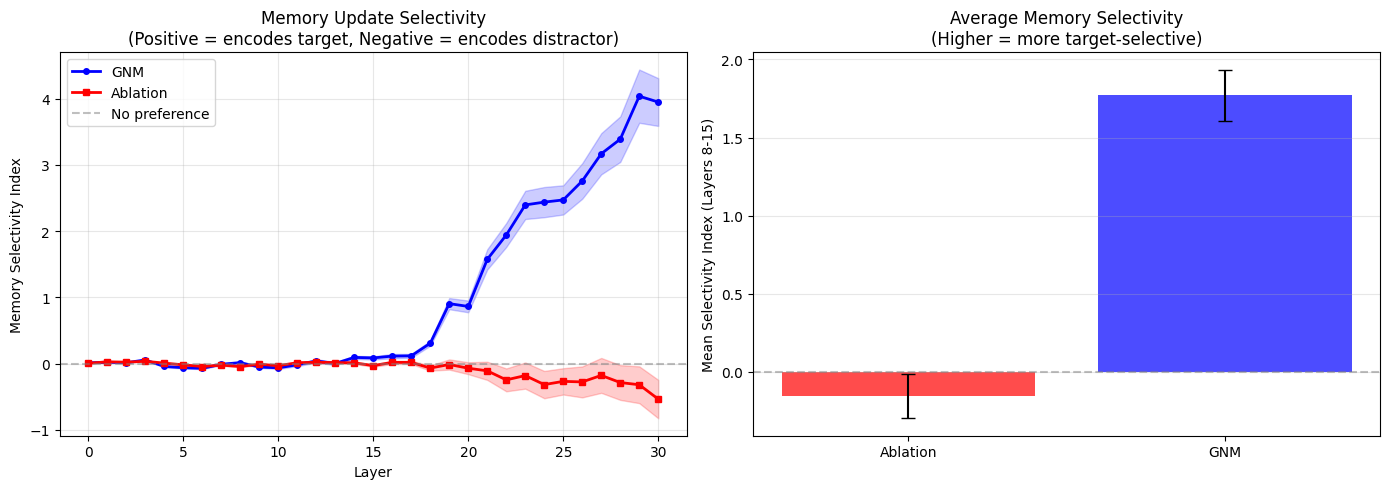


SUMMARY: Memory Selectivity Index

Overall Selectivity (mean across all layers):
  GNM: 0.9816
  Ablation: -0.0941
  Difference (GNM - Ablation): 1.0756

Selectivity in Middle Layers (8-15):
  GNM: 1.7710 ± 0.1645
  Ablation: -0.1564 ± 0.1423

Paired t-test (layers 16-32): t=19.012, p=0.000000
Cohen's d: 1.348
Percentage of examples where GNM > Ablation: 89.0%

INTERPRETATION:
✓ GNM memory updates are MORE selective for target information
  The memory delta is more aligned with target answer representations
  than with distractor answer representations, compared to Ablation.

Results saved to ../saved_evals/analysis/memory_selectivity_index.json


In [75]:
# =============================================
# ANALYSIS 6: Memory Selectivity Index
# 
# Key question: Does the memory delta preferentially encode TARGET information
# over DISTRACTOR information?
#
# Approach:
# 1. Get memory delta at each layer [L, 256, D]
# 2. Get hidden states of target & distractor answer tokens during injection
# 3. Define "selectivity direction" = normalize(target_hidden - distractor_hidden)
# 4. Project memory delta onto this direction
# 5. Positive = memory encodes more target-like info
#    Negative = memory encodes more distractor-like info
#
# This directly measures: How selectively does the memory update capture
# the target fact vs distractor facts?
# =============================================

print("=" * 60)
print("ANALYSIS 6: Memory Selectivity Index")
print("=" * 60)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.empty_cache()


@torch.no_grad()
def compute_memory_selectivity(wrapper, learning_instruction: str, document: str,
                                target_answer: str, distractor_answer: str):
    """
    Compute how much the memory delta aligns with target vs distractor direction.
    
    Returns per-layer selectivity scores:
    - Positive = memory update is more aligned with target
    - Negative = memory update is more aligned with distractor
    - Near zero = no preference
    """
    # Construct the full memory context
    memory_context = (
        f"<|learning_instruction_start|>{learning_instruction}<|learning_instruction_end|>"
        f"<|document_start|>{document}<|document_end|>"
    )
    
    # Find answer positions
    target_positions, ctx_ids, _ = find_answer_token_positions(wrapper, memory_context, target_answer)
    distractor_positions, _, _ = find_answer_token_positions(wrapper, memory_context, distractor_answer)
    
    if not target_positions or not distractor_positions:
        return None, "Answer not found"
    
    # Get memory delta [L, 256, D]
    delta = get_memory_delta_per_layer(wrapper, learning_instruction, document)  # [L, 256, D]
    
    # Get hidden states during injection [L+1, seq_len, D]
    result = get_hidden_states_during_injection(wrapper, learning_instruction, document)
    hidden_states = result['hidden_states']  # [L+1, seq_len, D]
    
    # Extract answer hidden states at each layer
    target_start, target_end = target_positions[0]
    distractor_start, distractor_end = distractor_positions[0]
    
    L = delta.shape[0]
    selectivity_scores = []
    
    for layer in range(L-1):
        # Get hidden states at this layer (use layer+1 because hidden_states includes embedding layer)
        # hidden_states[0] = embedding
        # hidden_states[1..L] = outputs of decoder layers 0..L-1
        # hidden_states[L+1] = post-final-LayerNorm (DON'T USE - it's scaled differently for LM head)
        # delta[layer] = memory update from decoder layer `layer`
        
        h_idx = layer + 1  # Align with decoder layer output
        # IMPORTANT: Cap at hidden_states.shape[0] - 2 to avoid the post-LayerNorm state
        # which has ~5x larger norm and is in a different representational space
        # if h_idx >= hidden_states.shape[0] - 1:
        #     h_idx = hidden_states.shape[0] - 2
        
        # Extract answer hidden states at this layer
        target_h = hidden_states[h_idx, target_start:target_end, :].mean(dim=0)  # [D]
        distractor_h = hidden_states[h_idx, distractor_start:distractor_end, :].mean(dim=0)  # [D]
        
        # Selectivity direction: normalized (target - distractor)
        selectivity_dir = (target_h - distractor_h).float()  # [D] - convert to float32
        selectivity_dir = F.normalize(selectivity_dir.unsqueeze(0), dim=1).squeeze(0)  # [D]
        
        # Memory delta at this layer - average across 256 memory tokens
        mem_delta = delta[layer].float().mean(dim=0).to(selectivity_dir.device)  # [D]
        
        # Project memory delta onto selectivity direction
        # Positive = more target-aligned, Negative = more distractor-aligned
        proj = (mem_delta @ selectivity_dir).item()
        selectivity_scores.append(proj)
    
    return np.array(selectivity_scores), None


def collect_selectivity_scores(wrapper, dataset, max_examples=None):
    """
    Collect memory selectivity scores across dataset.
    """
    all_scores = []
    errors = []
    
    total_examples = sum(len(entry["examples"]) for entry in dataset)
    if max_examples:
        total_examples = min(total_examples, max_examples)
    
    count = 0
    for data_entry in dataset:
        learning_instruction = data_entry["learning_instruction"]
        target_fact = data_entry["target_fact"]
        target_answer = target_fact['requested_rewrite']['target_new']['str']
        
        for example in data_entry["examples"]:
            if max_examples and count >= max_examples:
                break
                
            if count % 20 == 0:
                print(f"  Processing example {count}/{total_examples}...")
            
            distractor_answer = example['distractor_fact']['requested_rewrite']['target_new']['str']
            
            scores, error = compute_memory_selectivity(
                wrapper,
                learning_instruction=learning_instruction,
                document=example['document'],
                target_answer=target_answer,
                distractor_answer=distractor_answer
            )
            
            if error:
                errors.append({'count': count, 'error': error})
            else:
                all_scores.append(scores)
            
            count += 1
        
        if max_examples and count >= max_examples:
            break
    
    print(f"\n  Collected {len(all_scores)} valid examples, {len(errors)} errors")
    
    if all_scores:
        return np.stack(all_scores, axis=0)  # [N, L]
    return None


# =============================================
# Collect selectivity scores for both models
# =============================================

print("\nCollecting memory selectivity scores for GNM model...")
gnm_selectivity = collect_selectivity_scores(gnm_model_wrapper, dataset)

torch.cuda.empty_cache()

print("\nCollecting memory selectivity scores for Ablation model...")
abl_selectivity = collect_selectivity_scores(ablation_model_wrapper, dataset)

torch.cuda.empty_cache()

# =============================================
# Analysis and Plotting
# =============================================

# Average across examples
gnm_mean_selectivity = gnm_selectivity.mean(axis=0)  # [L]
abl_mean_selectivity = abl_selectivity.mean(axis=0)  # [L]

gnm_std_selectivity = gnm_selectivity.std(axis=0) / np.sqrt(gnm_selectivity.shape[0])
abl_std_selectivity = abl_selectivity.std(axis=0) / np.sqrt(abl_selectivity.shape[0])

num_layers = len(gnm_mean_selectivity)
layers = list(range(num_layers))

# =============================================
# Plot 1: Selectivity Index by Layer
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line plot with error bands
ax1 = axes[0]
ax1.plot(layers, gnm_mean_selectivity, 'b-o', label='GNM', linewidth=2, markersize=4)
ax1.fill_between(layers, 
                  gnm_mean_selectivity - 1.96*gnm_std_selectivity,
                  gnm_mean_selectivity + 1.96*gnm_std_selectivity, 
                  alpha=0.2, color='blue')
ax1.plot(layers, abl_mean_selectivity, 'r-s', label='Ablation', linewidth=2, markersize=4)
ax1.fill_between(layers,
                  abl_mean_selectivity - 1.96*abl_std_selectivity,
                  abl_mean_selectivity + 1.96*abl_std_selectivity,
                  alpha=0.2, color='red')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='No preference')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Memory Selectivity Index')
ax1.set_title('Memory Update Selectivity\n(Positive = encodes target, Negative = encodes distractor)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bar chart for overall selectivity (mean across layers 15-end, minus last layer)
ax2 = axes[1]
mid_layers = slice(15, -1)  # layers 15 to second-last layer
gnm_mid_mean = gnm_mean_selectivity[mid_layers].mean()
abl_mid_mean = abl_mean_selectivity[mid_layers].mean()
gnm_mid_se = gnm_selectivity[:, mid_layers].mean(axis=1).std() / np.sqrt(gnm_selectivity.shape[0])
abl_mid_se = abl_selectivity[:, mid_layers].mean(axis=1).std() / np.sqrt(abl_selectivity.shape[0])

bars = ax2.bar(['Ablation', 'GNM'], [abl_mid_mean, gnm_mid_mean], 
               yerr=[1.96*abl_mid_se, 1.96*gnm_mid_se],
               color=['red', 'blue'], alpha=0.7, capsize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Mean Selectivity Index (Layers 8-15)')
ax2.set_title('Average Memory Selectivity\n(Higher = more target-selective)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../saved_evals/analysis/memory_selectivity_index.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================
# Summary statistics
# =============================================

print("\n" + "=" * 60)
print("SUMMARY: Memory Selectivity Index")
print("=" * 60)

print(f"\nOverall Selectivity (mean across all layers):")
print(f"  GNM: {gnm_mean_selectivity.mean():.4f}")
print(f"  Ablation: {abl_mean_selectivity.mean():.4f}")
print(f"  Difference (GNM - Ablation): {gnm_mean_selectivity.mean() - abl_mean_selectivity.mean():.4f}")

print(f"\nSelectivity in Middle Layers (8-15):")
print(f"  GNM: {gnm_mid_mean:.4f} ± {1.96*gnm_mid_se:.4f}")
print(f"  Ablation: {abl_mid_mean:.4f} ± {1.96*abl_mid_se:.4f}")

# Statistical test
from scipy import stats

# Paired t-test on per-example mean selectivity
gnm_per_example_mean = gnm_selectivity[:, mid_layers].mean(axis=1)
abl_per_example_mean = abl_selectivity[:, mid_layers].mean(axis=1)
t_stat, p_value = stats.ttest_rel(gnm_per_example_mean, abl_per_example_mean)
print(f"\nPaired t-test (layers 16-32): t={t_stat:.3f}, p={p_value:.6f}")

# Effect size (Cohen's d)
diff = gnm_per_example_mean - abl_per_example_mean
cohens_d = diff.mean() / diff.std()
print(f"Cohen's d: {cohens_d:.3f}")

# What percentage of examples show higher GNM selectivity?
pct_gnm_higher = (gnm_per_example_mean > abl_per_example_mean).mean() * 100
print(f"Percentage of examples where GNM > Ablation: {pct_gnm_higher:.1f}%")

# =============================================
# Interpretation
# =============================================
print("\n" + "=" * 60)
print("INTERPRETATION:")
print("=" * 60)
if gnm_mid_mean > abl_mid_mean:
    print("✓ GNM memory updates are MORE selective for target information")
    print("  The memory delta is more aligned with target answer representations")
    print("  than with distractor answer representations, compared to Ablation.")
else:
    print("✗ Ablation memory updates are more selective for target information")

# Save results
save_path = "../saved_evals/analysis/memory_selectivity_index.json"
with open(save_path, "w") as f:
    json.dump({
        'gnm_mean_selectivity_per_layer': gnm_mean_selectivity.tolist(),
        'abl_mean_selectivity_per_layer': abl_mean_selectivity.tolist(),
        'gnm_std_selectivity_per_layer': gnm_std_selectivity.tolist(),
        'abl_std_selectivity_per_layer': abl_std_selectivity.tolist(),
        'gnm_mid_layer_mean': float(gnm_mid_mean),
        'abl_mid_layer_mean': float(abl_mid_mean),
        't_stat': float(t_stat),
        'p_value': float(p_value),
        'cohens_d': float(cohens_d),
        'pct_gnm_higher': float(pct_gnm_higher),
        'num_examples': int(gnm_selectivity.shape[0]),
    }, f, indent=4)
print(f"\nResults saved to {save_path}")

DIAGNOSTIC: Layer 31 Dropoff Investigation

  Processing 0/50...
  Processing 20/50...
  Processing 40/50...

  Processing 0/50...
  Processing 20/50...
  Processing 40/50...


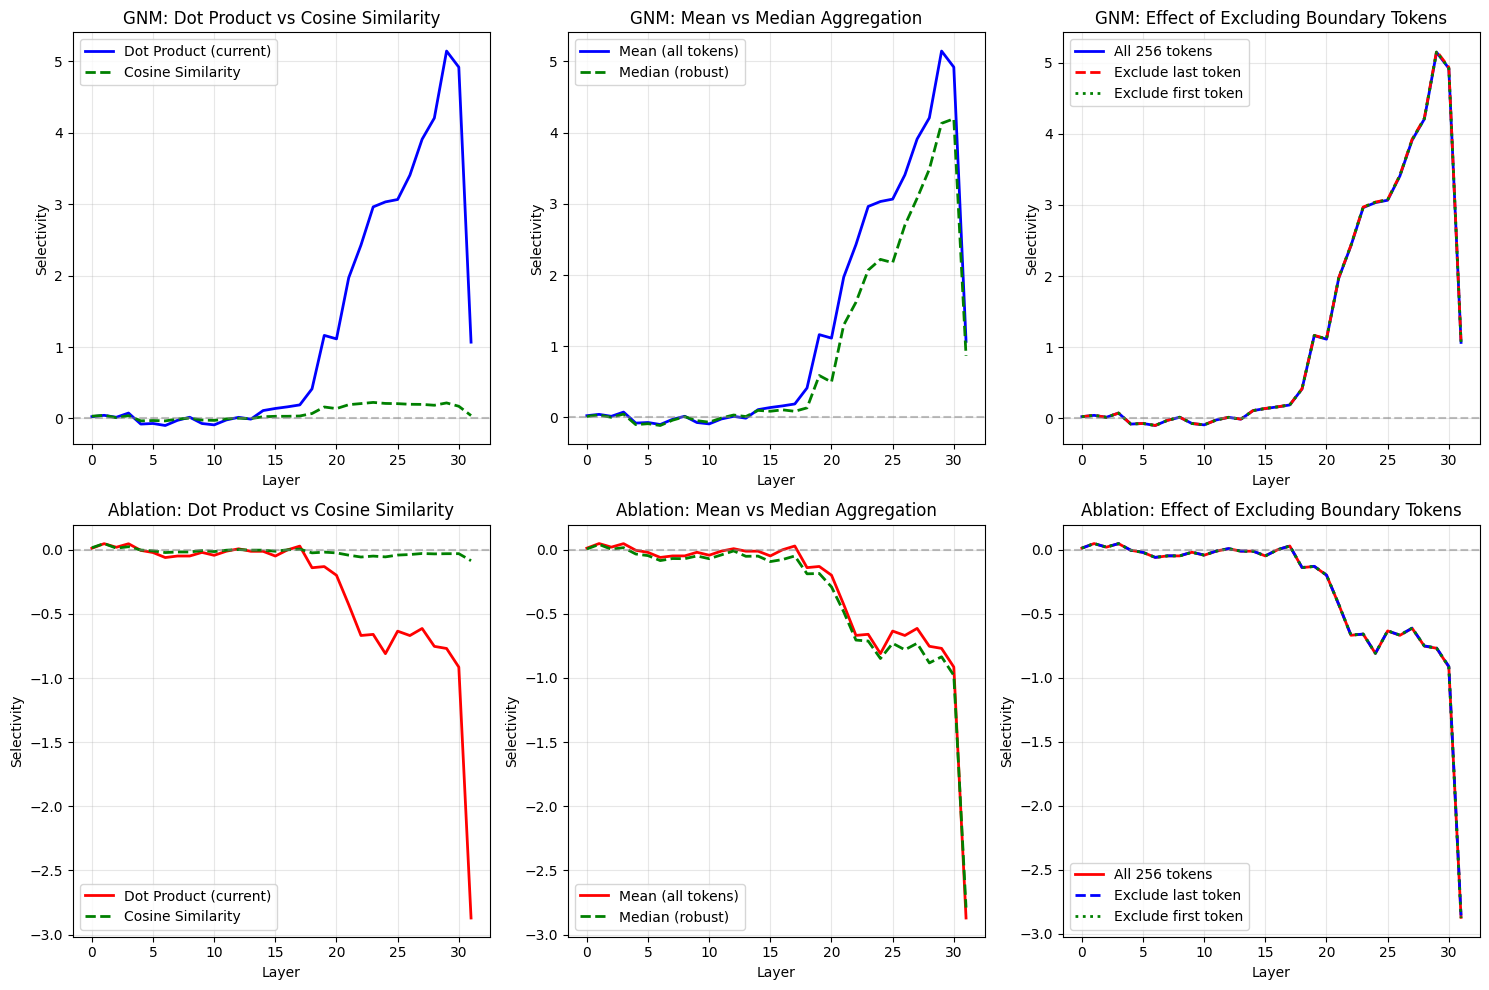


FINDINGS:

Layer 31 values:
  GNM dot product: 1.068
  GNM cosine sim:  0.041
  Abl dot product: -2.871
  Abl cosine sim:  -0.085

Does cosine similarity fix the dropoff?
  GNM layer 30 cosine: 0.171, layer 31: 0.041
  Abl layer 30 cosine: -0.030, layer 31: -0.085

Does excluding last token help?
  Abl layer 31 (all tokens): -2.871
  Abl layer 31 (excl last):  -2.855


In [68]:
# =============================================
# DIAGNOSTIC: What's causing the layer 31 dropoff?
# =============================================

print("=" * 60)
print("DIAGNOSTIC: Layer 31 Dropoff Investigation")
print("=" * 60)

@torch.no_grad()
def compute_memory_selectivity_detailed(wrapper, learning_instruction: str, document: str,
                                         target_answer: str, distractor_answer: str):
    """
    Compute detailed selectivity metrics:
    1. Dot product (current method)
    2. Cosine similarity (normalized both vectors)
    3. Per-token selectivity distribution (to find outliers)
    """
    memory_context = (
        f"<|learning_instruction_start|>{learning_instruction}<|learning_instruction_end|>"
        f"<|document_start|>{document}<|document_end|>"
    )
    
    target_positions, ctx_ids, _ = find_answer_token_positions(wrapper, memory_context, target_answer)
    distractor_positions, _, _ = find_answer_token_positions(wrapper, memory_context, distractor_answer)
    
    if not target_positions or not distractor_positions:
        return None, "Answer not found"
    
    delta = get_memory_delta_per_layer(wrapper, learning_instruction, document)  # [L, 256, D]
    result = get_hidden_states_during_injection(wrapper, learning_instruction, document)
    hidden_states = result['hidden_states']  # [L+1, seq_len, D]
    
    target_start, target_end = target_positions[0]
    distractor_start, distractor_end = distractor_positions[0]
    
    L = delta.shape[0]
    
    dot_products = []
    cosine_sims = []
    per_token_means = []  # Mean over tokens
    per_token_medians = []  # Median over tokens (robust to outliers)
    per_token_excluding_last = []  # Exclude last memory token
    per_token_excluding_first = []  # Exclude first memory token
    
    for layer in range(L):
        h_idx = min(layer + 1, hidden_states.shape[0] - 1)
        
        target_h = hidden_states[h_idx, target_start:target_end, :].mean(dim=0)
        distractor_h = hidden_states[h_idx, distractor_start:distractor_end, :].mean(dim=0)
        
        selectivity_dir = (target_h - distractor_h).float()
        selectivity_dir_norm = F.normalize(selectivity_dir.unsqueeze(0), dim=1).squeeze(0)
        
        # Method 1: Mean over tokens, then dot product (current method)
        mem_delta_mean = delta[layer].float().mean(dim=0).to(selectivity_dir.device)
        dot_prod = (mem_delta_mean @ selectivity_dir_norm).item()
        dot_products.append(dot_prod)
        
        # Method 2: Cosine similarity (normalize both)
        mem_delta_mean_norm = F.normalize(mem_delta_mean.unsqueeze(0), dim=1).squeeze(0)
        cos_sim = (mem_delta_mean_norm @ selectivity_dir_norm).item()
        cosine_sims.append(cos_sim)
        
        # Method 3: Per-token projections
        mem_delta_tokens = delta[layer].float().to(selectivity_dir.device)  # [256, D]
        per_token_proj = mem_delta_tokens @ selectivity_dir_norm  # [256]
        
        per_token_means.append(per_token_proj.mean().item())
        per_token_medians.append(per_token_proj.median().item())
        per_token_excluding_last.append(per_token_proj[:-1].mean().item())  # Exclude token 255
        per_token_excluding_first.append(per_token_proj[1:].mean().item())  # Exclude token 0
    
    return {
        'dot_products': np.array(dot_products),
        'cosine_sims': np.array(cosine_sims),
        'per_token_means': np.array(per_token_means),
        'per_token_medians': np.array(per_token_medians),
        'per_token_excluding_last': np.array(per_token_excluding_last),
        'per_token_excluding_first': np.array(per_token_excluding_first),
    }, None


def collect_detailed_selectivity(wrapper, dataset, max_examples=50):
    """Collect detailed selectivity metrics."""
    all_results = {
        'dot_products': [],
        'cosine_sims': [],
        'per_token_means': [],
        'per_token_medians': [],
        'per_token_excluding_last': [],
        'per_token_excluding_first': [],
    }
    
    count = 0
    for data_entry in dataset:
        learning_instruction = data_entry["learning_instruction"]
        target_answer = data_entry["target_fact"]['requested_rewrite']['target_new']['str']
        
        for example in data_entry["examples"]:
            if count >= max_examples:
                break
            if count % 20 == 0:
                print(f"  Processing {count}/{max_examples}...")
                
            distractor_answer = example['distractor_fact']['requested_rewrite']['target_new']['str']
            
            result, error = compute_memory_selectivity_detailed(
                wrapper, learning_instruction, example['document'],
                target_answer, distractor_answer
            )
            
            if not error:
                for key in all_results:
                    all_results[key].append(result[key])
            count += 1
        if count >= max_examples:
            break
    
    # Average across examples
    return {key: np.stack(val, axis=0).mean(axis=0) for key, val in all_results.items()}


# Collect for both models
print("\nCollecting detailed metrics for GNM...")
gnm_detailed = collect_detailed_selectivity(gnm_model_wrapper, dataset, max_examples=50)

print("\nCollecting detailed metrics for Ablation...")
abl_detailed = collect_detailed_selectivity(ablation_model_wrapper, dataset, max_examples=50)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
layers = list(range(len(gnm_detailed['dot_products'])))

# Row 1: Compare methods for GNM
ax = axes[0, 0]
ax.plot(layers, gnm_detailed['dot_products'], 'b-', label='Dot Product (current)', linewidth=2)
ax.plot(layers, gnm_detailed['cosine_sims'], 'g--', label='Cosine Similarity', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('GNM: Dot Product vs Cosine Similarity')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(layers, gnm_detailed['per_token_means'], 'b-', label='Mean (all tokens)', linewidth=2)
ax.plot(layers, gnm_detailed['per_token_medians'], 'g--', label='Median (robust)', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('GNM: Mean vs Median Aggregation')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(layers, gnm_detailed['per_token_means'], 'b-', label='All 256 tokens', linewidth=2)
ax.plot(layers, gnm_detailed['per_token_excluding_last'], 'r--', label='Exclude last token', linewidth=2)
ax.plot(layers, gnm_detailed['per_token_excluding_first'], 'g:', label='Exclude first token', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('GNM: Effect of Excluding Boundary Tokens')
ax.legend()
ax.grid(True, alpha=0.3)

# Row 2: Same for Ablation
ax = axes[1, 0]
ax.plot(layers, abl_detailed['dot_products'], 'r-', label='Dot Product (current)', linewidth=2)
ax.plot(layers, abl_detailed['cosine_sims'], 'g--', label='Cosine Similarity', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('Ablation: Dot Product vs Cosine Similarity')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(layers, abl_detailed['per_token_means'], 'r-', label='Mean (all tokens)', linewidth=2)
ax.plot(layers, abl_detailed['per_token_medians'], 'g--', label='Median (robust)', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('Ablation: Mean vs Median Aggregation')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.plot(layers, abl_detailed['per_token_means'], 'r-', label='All 256 tokens', linewidth=2)
ax.plot(layers, abl_detailed['per_token_excluding_last'], 'b--', label='Exclude last token', linewidth=2)
ax.plot(layers, abl_detailed['per_token_excluding_first'], 'g:', label='Exclude first token', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Selectivity')
ax.set_title('Ablation: Effect of Excluding Boundary Tokens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../saved_evals/analysis/selectivity_diagnostic.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "=" * 60)
print("FINDINGS:")
print("=" * 60)
print(f"\nLayer 31 values:")
print(f"  GNM dot product: {gnm_detailed['dot_products'][-1]:.3f}")
print(f"  GNM cosine sim:  {gnm_detailed['cosine_sims'][-1]:.3f}")
print(f"  Abl dot product: {abl_detailed['dot_products'][-1]:.3f}")
print(f"  Abl cosine sim:  {abl_detailed['cosine_sims'][-1]:.3f}")

print(f"\nDoes cosine similarity fix the dropoff?")
print(f"  GNM layer 30 cosine: {gnm_detailed['cosine_sims'][-2]:.3f}, layer 31: {gnm_detailed['cosine_sims'][-1]:.3f}")
print(f"  Abl layer 30 cosine: {abl_detailed['cosine_sims'][-2]:.3f}, layer 31: {abl_detailed['cosine_sims'][-1]:.3f}")

print(f"\nDoes excluding last token help?")
print(f"  Abl layer 31 (all tokens): {abl_detailed['per_token_means'][-1]:.3f}")
print(f"  Abl layer 31 (excl last):  {abl_detailed['per_token_excluding_last'][-1]:.3f}")

  Processing 0/200...
  Processing 40/200...
  Processing 80/200...
  Processing 120/200...
  Processing 160/200...
  Processing 0/200...
  Processing 40/200...
  Processing 80/200...
  Processing 120/200...
  Processing 160/200...


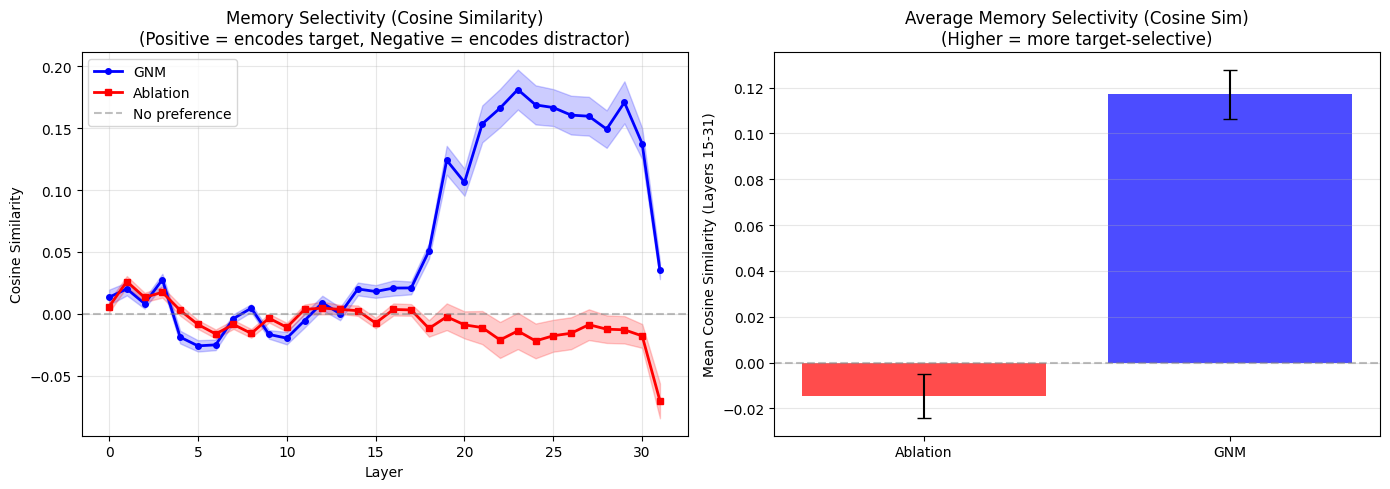


Cosine Similarity Summary (Layers 15-31):
  GNM:      0.1171 ± 0.0107
  Ablation: -0.0146 ± 0.0097
  Difference: 0.1317

Paired t-test: t=19.170, p=4.33e-47
Cohen's d: 1.359
Percentage of examples where GNM > Ablation: 88.5%


In [71]:
# =============================================
# Cosine Similarity Version of Selectivity Plot
# (Same format as Analysis 6 but using cosine similarity)
# =============================================

# First, re-collect per-example cosine similarities for error bars
@torch.no_grad()
def collect_cosine_selectivity_per_example(wrapper, dataset, max_examples=None):
    """Collect per-example cosine similarity selectivity scores."""
    all_cosine_sims = []  # List of [L] arrays
    
    total_examples = sum(len(entry["examples"]) for entry in dataset)
    if max_examples:
        total_examples = min(total_examples, max_examples)
    
    count = 0
    for data_entry in dataset:
        learning_instruction = data_entry["learning_instruction"]
        target_answer = data_entry["target_fact"]['requested_rewrite']['target_new']['str']
        
        for example in data_entry["examples"]:
            if max_examples and count >= max_examples:
                break
            if count % 40 == 0:
                print(f"  Processing {count}/{total_examples}...")
                
            distractor_answer = example['distractor_fact']['requested_rewrite']['target_new']['str']
            
            memory_context = (
                f"<|learning_instruction_start|>{learning_instruction}<|learning_instruction_end|>"
                f"<|document_start|>{example['document']}<|document_end|>"
            )
            
            target_positions, _, _ = find_answer_token_positions(wrapper, memory_context, target_answer)
            distractor_positions, _, _ = find_answer_token_positions(wrapper, memory_context, distractor_answer)
            
            if not target_positions or not distractor_positions:
                count += 1
                continue
            
            delta = get_memory_delta_per_layer(wrapper, learning_instruction, example['document'])
            result = get_hidden_states_during_injection(wrapper, learning_instruction, example['document'])
            hidden_states = result['hidden_states']
            
            target_start, target_end = target_positions[0]
            distractor_start, distractor_end = distractor_positions[0]
            
            L = delta.shape[0]
            cosine_sims = []
            
            for layer in range(L):
                h_idx = min(layer + 1, hidden_states.shape[0] - 1)
                target_h = hidden_states[h_idx, target_start:target_end, :].mean(dim=0)
                distractor_h = hidden_states[h_idx, distractor_start:distractor_end, :].mean(dim=0)
                
                selectivity_dir = F.normalize((target_h - distractor_h).float().unsqueeze(0), dim=1).squeeze(0)
                mem_delta_mean = delta[layer].float().mean(dim=0).to(selectivity_dir.device)
                mem_delta_norm = F.normalize(mem_delta_mean.unsqueeze(0), dim=1).squeeze(0)
                
                cos_sim = (mem_delta_norm @ selectivity_dir).item()
                cosine_sims.append(cos_sim)
            
            all_cosine_sims.append(np.array(cosine_sims))
            count += 1
        
        if max_examples and count >= max_examples:
            break
    
    return np.stack(all_cosine_sims, axis=0)  # [N, L]

print("Collecting per-example cosine selectivity for GNM...")
gnm_cosine_per_example = collect_cosine_selectivity_per_example(gnm_model_wrapper, dataset)
print("Collecting per-example cosine selectivity for Ablation...")
abl_cosine_per_example = collect_cosine_selectivity_per_example(ablation_model_wrapper, dataset)

# Compute means and standard errors
gnm_cosine_mean = gnm_cosine_per_example.mean(axis=0)
abl_cosine_mean = abl_cosine_per_example.mean(axis=0)
gnm_cosine_se = gnm_cosine_per_example.std(axis=0) / np.sqrt(gnm_cosine_per_example.shape[0])
abl_cosine_se = abl_cosine_per_example.std(axis=0) / np.sqrt(abl_cosine_per_example.shape[0])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
layers = list(range(len(gnm_cosine_mean)))

# Left: Line plot with error bands
ax1 = axes[0]
ax1.plot(layers, gnm_cosine_mean, 'b-o', label='GNM', linewidth=2, markersize=4)
ax1.fill_between(layers, 
                  gnm_cosine_mean - 1.96*gnm_cosine_se,
                  gnm_cosine_mean + 1.96*gnm_cosine_se, 
                  alpha=0.2, color='blue')
ax1.plot(layers, abl_cosine_mean, 'r-s', label='Ablation', linewidth=2, markersize=4)
ax1.fill_between(layers,
                  abl_cosine_mean - 1.96*abl_cosine_se,
                  abl_cosine_mean + 1.96*abl_cosine_se,
                  alpha=0.2, color='red')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='No preference')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Cosine Similarity')
ax1.set_title('Memory Selectivity (Cosine Similarity)\n(Positive = encodes target, Negative = encodes distractor)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Bar chart for layers 15-31 (second half) with error bars
ax2 = axes[1]
late_layers_idx = slice(15, 32)

# Per-example mean over late layers, then compute mean and SE across examples
gnm_per_example_late_mean = gnm_cosine_per_example[:, late_layers_idx].mean(axis=1)
abl_per_example_late_mean = abl_cosine_per_example[:, late_layers_idx].mean(axis=1)

gnm_late_mean = gnm_per_example_late_mean.mean()
abl_late_mean = abl_per_example_late_mean.mean()
gnm_late_se = gnm_per_example_late_mean.std() / np.sqrt(len(gnm_per_example_late_mean))
abl_late_se = abl_per_example_late_mean.std() / np.sqrt(len(abl_per_example_late_mean))

bars = ax2.bar(['Ablation', 'GNM'], [abl_late_mean, gnm_late_mean], 
               yerr=[1.96*abl_late_se, 1.96*gnm_late_se],
               color=['red', 'blue'], alpha=0.7, capsize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Mean Cosine Similarity (Layers 15-31)')
ax2.set_title('Average Memory Selectivity (Cosine Sim)\n(Higher = more target-selective)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../saved_evals/analysis/memory_selectivity_cosine.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print(f"\nCosine Similarity Summary (Layers 15-31):")
print(f"  GNM:      {gnm_late_mean:.4f} ± {1.96*gnm_late_se:.4f}")
print(f"  Ablation: {abl_late_mean:.4f} ± {1.96*abl_late_se:.4f}")
print(f"  Difference: {gnm_late_mean - abl_late_mean:.4f}")

# Statistical test
t_stat_cosine, p_value_cosine = stats.ttest_rel(gnm_per_example_late_mean, abl_per_example_late_mean)
print(f"\nPaired t-test: t={t_stat_cosine:.3f}, p={p_value_cosine:.2e}")

# Effect size
diff_cosine = gnm_per_example_late_mean - abl_per_example_late_mean
cohens_d_cosine = diff_cosine.mean() / diff_cosine.std()
print(f"Cohen's d: {cohens_d_cosine:.3f}")

pct_gnm_higher_cosine = (gnm_per_example_late_mean > abl_per_example_late_mean).mean() * 100
print(f"Percentage of examples where GNM > Ablation: {pct_gnm_higher_cosine:.1f}%")

In [72]:
# Add this diagnostic cell to check layer alignment

@torch.no_grad()
def debug_layer_alignment(wrapper, dataset):
    """Check if there's an off-by-one error in layer indexing."""
    example = dataset[0]["examples"][0]
    learning_instruction = dataset[0]["learning_instruction"]
    document = example["document"]
    
    # Get delta shape
    delta = get_memory_delta_per_layer(wrapper, learning_instruction, document)
    print(f"Delta shape: {delta.shape}")  # Should be [L, 256, D]
    
    # Get hidden states shape
    result = get_hidden_states_during_injection(wrapper, learning_instruction, document)
    hidden_states = result['hidden_states']
    print(f"Hidden states shape: {hidden_states.shape}")  # Should be [L+1, seq_len, D]
    
    # Check norms at each layer to see if there's a pattern break
    print("\nDelta norms per layer:")
    for l in range(delta.shape[0]):
        norm = delta[l].float().norm().item()
        print(f"  Layer {l}: {norm:.2f}")
    
    print("\nHidden state norms per layer (at position 0):")
    for l in range(hidden_states.shape[0]):
        norm = hidden_states[l, 0].float().norm().item()
        print(f"  Layer {l}: {norm:.2f}")
    
    # Check if layer 31 delta has unusual properties
    print(f"\nLayer 31 delta stats:")
    d31 = delta[31].float()
    print(f"  Mean: {d31.mean().item():.4f}")
    print(f"  Std:  {d31.std().item():.4f}")
    print(f"  Min:  {d31.min().item():.4f}")
    print(f"  Max:  {d31.max().item():.4f}")
    
    print(f"\nLayer 30 delta stats (for comparison):")
    d30 = delta[30].float()
    print(f"  Mean: {d30.mean().item():.4f}")
    print(f"  Std:  {d30.std().item():.4f}")
    print(f"  Min:  {d30.min().item():.4f}")
    print(f"  Max:  {d30.max().item():.4f}")

debug_layer_alignment(gnm_model_wrapper, dataset)
debug_layer_alignment(ablation_model_wrapper, dataset)

Delta shape: torch.Size([32, 256, 4096])
Hidden states shape: torch.Size([33, 125, 4096])

Delta norms per layer:
  Layer 0: 31.04
  Layer 1: 33.22
  Layer 2: 46.57
  Layer 3: 58.25
  Layer 4: 71.14
  Layer 5: 76.72
  Layer 6: 93.10
  Layer 7: 93.97
  Layer 8: 98.72
  Layer 9: 106.91
  Layer 10: 111.77
  Layer 11: 116.91
  Layer 12: 128.06
  Layer 13: 139.76
  Layer 14: 151.43
  Layer 15: 163.65
  Layer 16: 187.88
  Layer 17: 209.93
  Layer 18: 240.39
  Layer 19: 274.08
  Layer 20: 302.37
  Layer 21: 349.11
  Layer 22: 374.23
  Layer 23: 398.03
  Layer 24: 422.66
  Layer 25: 443.43
  Layer 26: 482.36
  Layer 27: 540.76
  Layer 28: 595.65
  Layer 29: 645.05
  Layer 30: 757.66
  Layer 31: 884.87

Hidden state norms per layer (at position 0):
  Layer 0: 0.47
  Layer 1: 1.05
  Layer 2: 1.72
  Layer 3: 2.25
  Layer 4: 3.17
  Layer 5: 3.88
  Layer 6: 4.37
  Layer 7: 5.15
  Layer 8: 6.46
  Layer 9: 7.36
  Layer 10: 7.50
  Layer 11: 7.83
  Layer 12: 7.39
  Layer 13: 8.01
  Layer 14: 8.09
  Lay